In [1]:
import pandas as pd
from glob import glob
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from keras import optimizers
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import regularizers
from src.utils import plot_history, plot_confusion_matrix, full_multiclass_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
csv = sorted(glob('./data/Master*.csv')) 
print(csv[-1])
ds = pd.read_csv(csv[-1])
# opens a random set of data and checks for number of unique comments

./data/Master_monuments_comments_v0_1.csv


we iterate up to the 4000th word and checks how many words we need to check through for unique ness.


In [ ]:
ulist = [len(np.unique(np.array([c[:i] for c in ds.comment[:3000]]))) for i in range(0,4000,25)]
comment_list = np.array([c for c in ds.comment])

In [ ]:
f, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(np.arange(0,4000,25),ulist)
ax.grid(alpha=0.5)
ax.set_xlabel('Comment character limit')
ax.set_ylabel('Number of unique comments')
f.savefig('./output/unique_plot.png',dpi=300,bbox_inches='tight')

In [ ]:
ucomment, uix = np.unique(comment_list, return_index=True)

In [ ]:
len(uix)
#this means we have 9444 unique comments

In [4]:
# done with check above is merely to teach ourselve that we need to use only so many characters

In [15]:
ds.rename(index=str, columns={"comment":"text"}, inplace=True)
data = ds[['text', 'sentiment']].fillna(0)

In [16]:
#data = data[data.sentiment != '0']
#makes everything lower case
data['text'] = data['text'].astype(str)
data['text'] = data['text'].apply(lambda x: x.lower()) 
data['text'] = data['text'].apply(lambda x: re.sub(r'(?<=[.,!?])(?=[^\s])',' ',x))
#makes everything lower case
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x)) 
#removes all the 

print(len(data[data['sentiment'] == 0])) #neutral
print(len(data[data['sentiment'] == 1])) #positive
print(len(data[data['sentiment'] == 2])) #negative
print(len(data[data['sentiment'] == 999])) #error?
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

172
9101
703
0


In [17]:
#data['text'] = [x.encode('ascii') for x in data['text']]
max_features = 4000
tokenizer = Tokenizer(nb_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(data['text'].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [18]:
alldata = data
testdata = alldata.iloc[-100:]
traindata = alldata.iloc[:-100]

In [29]:
Y = pd.get_dummies(data['sentiment']).values
#ix = np.argmax(Y, axis=1)!=3 #all the good data, if there were errors
ix = int(len(X) - (len(X)*0.05))

In [30]:
ix

9477

In [32]:
X_train, X_val, Y_train, Y_val = train_test_split(X[:ix],Y[:ix], \
                                                  test_size = 0.1, random_state = 42)
X_test = X[ix:]
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape)

(8529, 858) (8529, 3)
(948, 858) (948, 3)
(499, 858)


In [33]:
y = np.argmax(Y_train, axis=1)

In [2]:
7779/(151+7779+599)
599/(151+7779+599)

0.07023097666783913

(array([ 151.,    0.,    0.,    0.,    0., 7779.,    0.,    0.,    0.,
         599.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

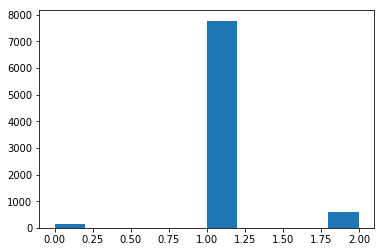

In [34]:
plt.hist(y)

In [35]:
class_weight = class_weight.compute_class_weight('balanced',\
                                                 np.unique(y),y)

In [36]:
embed_dim = 256 
lstm_out = 256

model = Sequential()
model.add(Embedding(4800, embed_dim, input_length = X.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(3,activation='softmax',kernel_regularizer=regularizers.l2(0.01),\
               activity_regularizer=regularizers.l1(0.01)))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', \
              metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, dropout=0.2, recurrent_dropout=0.2)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 858, 256)          1228800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 1,754,883
Trainable params: 1,754,883
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
batch_size = 500 
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size,\
                    class_weight=class_weight, validation_data=(X_val, Y_val),\
                    shuffle=True)

Train on 7676 samples, validate on 853 samples
Epoch 1/10
7676/7676 [==============================] - 40s 5ms/step - loss: 5.6197 - acc: 0.8751 - val_loss: 4.7415 - val_acc: 0.9226
Epoch 2/10
7676/7676 [==============================] - 38s 5ms/step - loss: 5.2447 - acc: 0.9160 - val_loss: 4.6504 - val_acc: 0.9308
Epoch 3/10
7676/7676 [==============================] - 39s 5ms/step - loss: 5.1818 - acc: 0.9402 - val_loss: 4.6142 - val_acc: 0.9508
Epoch 4/10
7676/7676 [==============================] - 39s 5ms/step - loss: 5.1330 - acc: 0.9506 - val_loss: 4.5796 - val_acc: 0.9555
Epoch 5/10
7676/7676 [==============================] - 38s 5ms/step - loss: 5.0889 - acc: 0.9597 - val_loss: 4.5670 - val_acc: 0.9625
Epoch 6/10
7676/7676 [==============================] - 38s 5ms/step - loss: 5.0627 - acc: 0.9678 - val_loss: 4.5667 - val_acc: 0.9543
Epoch 7/10
7676/7676 [==============================] - 38s 5ms/step - loss: 5.0424 - acc: 0.9741 - val_loss: 4.5614 - val_acc: 0.9566
Epoch 8/

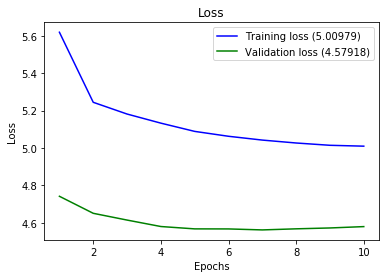

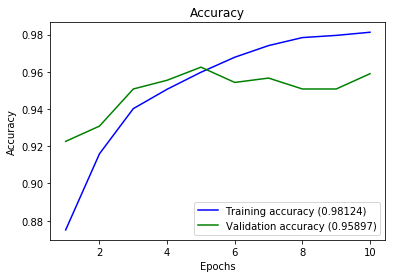

In [38]:
plot_history(history, 'prototype_history')

Accuracy : 0.9630801687763713

Classification Report
             precision    recall  f1-score   support

          0    1.00000   0.31250   0.47619        16
          1    0.97477   0.99415   0.98437       855
          2    0.81690   0.75325   0.78378        77

avg / total    0.96237   0.96308   0.95950       948

[[  5   3   8]
 [  0 850   5]
 [  0  19  58]]


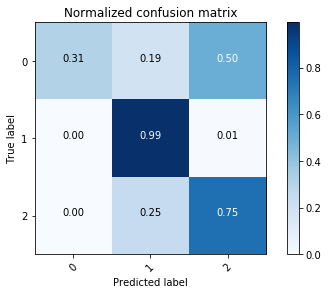

In [39]:
full_multiclass_report(model, X_val, Y_val, np.arange(3), norm=True, outfile='prototype')

In [40]:
y_test = model.predict(X_test)

In [41]:
yhat_neg =np.where(np.argmax(y_test, axis=1)==2)

In [42]:
yhat_neg[0]

array([ 16,  33,  76, 119, 216, 255, 258, 264, 271, 304, 345, 374, 386,
       389, 400, 409, 430, 444, 447, 479])

In [43]:
np.sum(np.argmax(Y_train, axis=1)==2)/len(Y_train)

0.07023097666783913

In [44]:
X_test[yhat_neg[0]]

array([[  0,   0,   0, ...,  50, 375, 169],
       [  0,   0,   0, ..., 219,   5,  11],
       [  0,   0,   0, ..., 219,   5,  11],
       ...,
       [  0,   0,   0, ..., 219,   5,  11],
       [  0,   0,   0, ..., 219,   5,  11],
       [  0,   0,   0, ...,   3,  24,  25]], dtype=int32)

In [62]:
data['text'][ix:][400]

'dear interior secretary zinkei live near eagle point in the rogue valley of oregon the cascadesiskiyou national monument is the best recreation area near me i use it frequently during the summer for hiking mountain biking birding and just enjoying the natural area there is a lot of industrial forest land in our area but it is tree plantations  and does not offer the same quality of recreation and wildlife habitat the cascade siskiyou national monument has strong support from people throughout the rogue valley even though it is a fairly new area it has already attracted a considerable fan base the proximity to the university in ashland  guarantees a stream of students  both in classes and outside of class  a lot of people from the valley trailer horses to the monument to enjoy the cooler temperatures and excellent riding trails  there is not that much good recreation land situated so close to us please ensure that this area is protected for our use and enjoyment sincerely sandy greenwa